In [1]:
from bandits.policies import GaussianThompson, UCB, Wilcoxon
import numpy as np
from bandits.monte_carlo_helpers import EvaluateGaussianMAB, simulate_standard_normal
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
mu = np.array([4.0, 2.0])  # 2.0, 3.0, 4.0])  # true means of the arms
K = len(mu)  # number of arms
T = 1_000  # number of time steps
R = 2_500  # number of repetitions


simulated_noise = simulate_standard_normal(T, K, R)
study = EvaluateGaussianMAB(
    simulated_noise=simulated_noise,
)

In [3]:
policies = {
    #    "epsilon-greedy (epsilon=0.1)": lambda K, R=1: EpsilonGreedy(K, R, epsilon=0.1),
    #    "epsilon-greedy (epsilon=0.05)": lambda K, R=1: EpsilonGreedy(K, R, epsilon=0.05),
    "UCB (c=1.0)": lambda K, R=1: UCB(K, R, c=1.0),
    "Thompson sampling (prior_var=1.0)": lambda K, R=1: GaussianThompson(
        K, R, prior_var=1.0
    ),
    "Wilcoxon": lambda K, R=1: Wilcoxon(K, R),
}

In [4]:
results = {}
for name, policy_factory in policies.items():
    print(f"Running policy: {name}")
    results[name] = study.generate_outcomes(mu, policy_factory)

Running policy: UCB (c=1.0)
Running policy: Thompson sampling (prior_var=1.0)
Running policy: Wilcoxon


In [5]:
mu_opt = mu.max()
gaps = mu_opt - mu
coefficient_mean = sum(np.where(gaps > 0, 2 / gaps, 0))
coefficient_var = sum(np.where(gaps > 0, 8 / gaps**2, 0))

/tmp/ipykernel_343060/3069352061.py:3: RuntimeWarning: divide by zero encountered in divide
  coefficient_mean = sum(np.where(gaps > 0, 2 / gaps, 0))
/tmp/ipykernel_343060/3069352061.py:4: RuntimeWarning: divide by zero encountered in divide
  coefficient_var = sum(np.where(gaps > 0, 8 / gaps**2, 0))


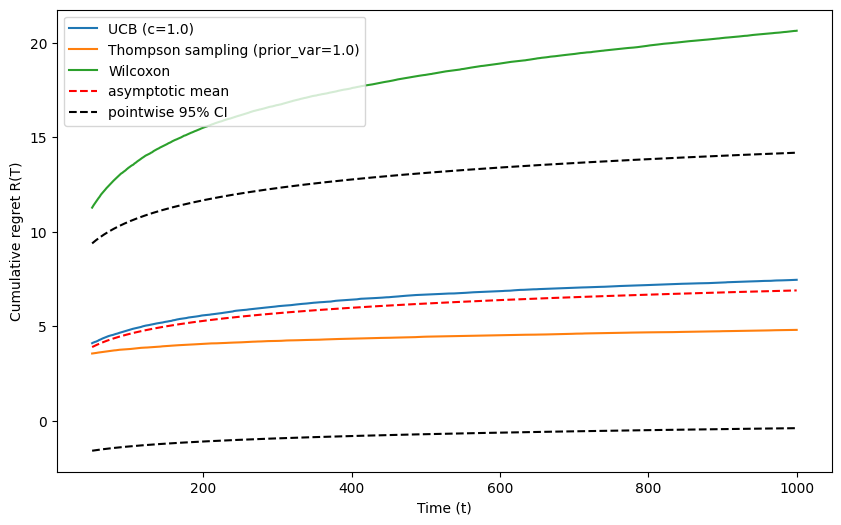

In [6]:
plt.figure(figsize=(10, 6))

start = 50

for name, sim_output in results.items():
    metrics = sim_output.compute_metrics_cum_regret_distribution()

    plt.plot(range(start, T + 1, 1), metrics["mean"][start - 1 :], label=name)

mean_asy = coefficient_mean * np.log(np.arange(start, T + 1))
upper_asy = mean_asy + 1.96 * np.sqrt(coefficient_var * np.log(np.arange(start, T + 1)))
lower_asy = mean_asy - 1.96 * np.sqrt(coefficient_var * np.log(np.arange(start, T + 1)))

plt.plot(
    range(start, T + 1, 1),
    mean_asy,
    label="asymptotic mean",
    linestyle="--",
    color="red",
)
plt.plot(
    range(start, T + 1, 1),
    upper_asy,
    label="pointwise 95% CI",
    linestyle="--",
    color="black",
)
plt.plot(range(start, T + 1, 1), lower_asy, linestyle="--", color="black")

plt.xlabel("Time (t)")
plt.ylabel("Cumulative regret R(T)")
plt.legend()
plt.show()

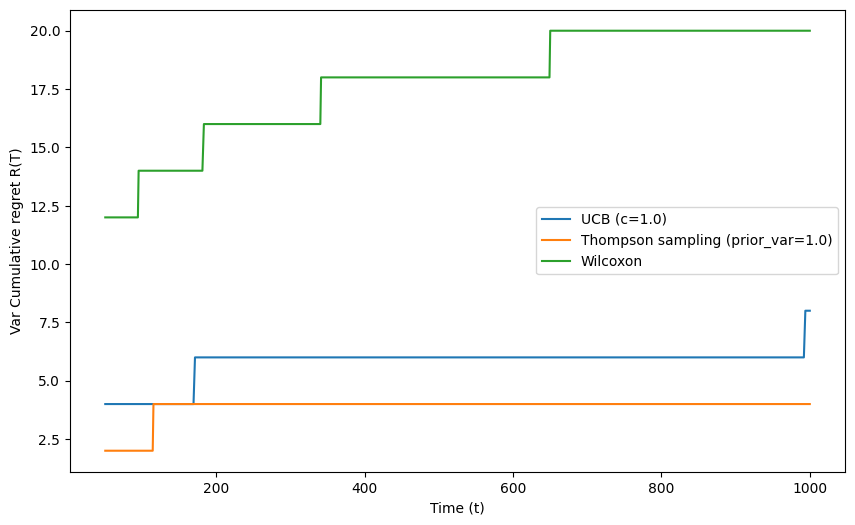

In [7]:
plt.figure(figsize=(10, 6))

start = 50

for name, sim_output in results.items():
    metrics = sim_output.compute_metrics_cum_regret_distribution()

    plt.plot(range(start, T + 1, 1), metrics["median"][start - 1 :], label=name)


plt.xlabel("Time (t)")
plt.ylabel("Var Cumulative regret R(T)")
plt.legend()
plt.show()